### Устанавливаем библиотеки 




Задача № 3 (для 2 курса)
 
Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/



# Решение.

1. task_text: разбить на предложения. Выявить функционал. FIO_POSITION: ФИО, должность, функционал, отдел (не необходимо).
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


In [120]:
#!pip install networkx
#!pip install --upgrade networkx
#!pip install pygraphviz pydot lxml
#!pip install pygraphviz
#!pytest networkx
#!pytest --pyargs networkx
#! pip install pymorphy2
#! pip install -U pip setuptools wheel
#! pip install -U spacy 
#! python -m spacy download en_core_web_sm
#! python -m spacy download ru_core_news_sm
#! pip install --user -U nltk
#! pip install -U liblinear-official
#! pip install natasha
#! pip install ipymarkup
#! pip install transformers sentencepiece sacremoses
#!pip install pymorphy2[fast]
#!pip install natasha spacy==3.3

#!python -m spacy download ru_core_news_sm
#!pip install tensorflow-text spacy==3.3
#!python -m spacy download ru_core_news_sm
#!pip install pymorphy2[fast] 


In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from yargy.tokenizer import MorphTokenizer
from yargy import rule, or_, Parser
from yargy.predicates import eq, type as _t, normalized, gram
from ipymarkup import show_span_box_markup, show_span_line_markup
from yargy.pipelines import morph_pipeline as mp, caseless_pipeline as cp
from yargy.interpretation import fact
from IPython.display import display

from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForTokenClassification

# Морфологический анализ
import pymorphy2

# Синтаксический анализ
import spacy
from spacy import displacy

import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
import gensim.models


import requests
import nltk
import spacy
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2

import spacy
from spacy import displacy

2023-01-21 11:21:30.773309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open('merged_data.json', "r") as readFile:
            merge_data = json.load(readFile)

### Определяем количество департаментов в компании

In [3]:
DEPARTMENTS = []
for n in range(10000):
    try:
        for i in range(1,30):
            DEPARTMENTS.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_groups'])
    except KeyError:
        continue
    except IndexError:
        continue


In [5]:
FIO_POSITION = []
for n in range(10000):
    try:
        for i in range(1,20):
            FIO_POSITION.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_people'])
    except KeyError:
        continue
    except IndexError:
        continue

In [6]:
TASK = []
for n in range(10000):
    try:
        for i in range(1,30):
            TASK.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_text'])
    except KeyError:
        continue
    except IndexError:
        continue

In [7]:
POSITION = []
for n in range(10000):
    try:
        for i in range(1,30):
            POSITION.append(merge_data[n]['Tasks']['Global_supervisor'][i])
    except KeyError:
        continue
    except IndexError:
        continue

### Очищаем данные

In [9]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = " ".join(line)
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words

In [12]:
def token_words_split(text: str):
    pouch_of_words = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            TOKENIZER = word_tokenize(line)
            pouch_of_words.append(TOKENIZER)
    return pouch_of_words

pouch_of_words = token_words_split(POSITION)

In [101]:
#def token_tf_text_split(text: str):
#    pouch_of_words = []
#    if type(text) == list:
#        for line in text:
#            line = " ".join(line) 
#            sp_model = line
#            tokenizer = tf_text.SentencepieceTokenizer(sp_model, out_type=tf.string)
#            tokens = tokenizer.tokenize([line])
#            pouch_of_words.append([token.decode('utf-8') for token in tokens.to_list()[0]])
#    return pouch_of_words

#token_tf_text_split(POSITION[:10])

In [19]:
text = FIO_POSITION[:2]

def split_spacy(text: str):
    pouch_of_words = []
    nlp = spacy.load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words


In [17]:
def sentence(text: str):
    nltk.download('punkt')
    sentences = sent_tokenize(text)
    return sentences


### Морфологический анализ

In [13]:
morph = pymorphy2.MorphAnalyzer()

In [21]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
        try:
            for n in range(len(pouch_of_words[0])):
                           morph_words.append(morph.parse(pouch_of_words[n][n]))
        except KeyError:
                       continue
    return morph_words


### Синтаксический анализ

In [15]:
nlp_synt = spacy.load('ru_core_news_sm')

### Разделяем текст на предложения.

In [22]:
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            nltk.download('punkt')
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(FIO_POSITION[10:12])

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
 
    Doc
)


In [9]:
 
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [10]:
syntax_parser = NewsSyntaxParser(emb)


In [11]:
text = str(FIO_POSITION[:2000])


In [12]:
doc_n = Doc(text)

In [15]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [40]:
#doc_n.parse_syntax(syntax_parser)

In [17]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [18]:
#doc_n.sents[0].syntax.print()

### Выявление ФИО

In [19]:
FIO = []

for tocken in doc_n.tokens:
    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
        if tocken.rel == 'appos':
            surn = tocken.text 
            if surn in FIO:
                pass
            else:
                FIO.append(surn)
        elif tocken.rel == 'flat:name':
            IO = tocken.text + '.'      
            FIO.append(IO)
           


In [54]:
doc_n.segment(segmenter) 

In [55]:
doc_n.tag_morph(morph_tagger)

In [56]:
doc_n.tag_ner(ner_tagger)

In [ ]:
doc_n.parse_syntax(syntax_parser)

In [21]:
#display(doc_n.tokens[:5])

In [ ]:
display(doc_n.sents)

In [139]:
#display(doc_n.tokens)

In [57]:
for span in doc_n.spans:
    span.normalize(morph_vocab)
    print(span)

keywords = {_.text: _.normal for _ in doc_n.spans if _.text != _.normal}

DocSpan(start=125, stop=138, type='PER', text='Кравцову И.Е.', tokens=[...], normal='Кравцов И.Е.')
DocSpan(start=228, stop=237, type='ORG', text='Службы ИТ', tokens=[...], normal='Служба ИТ')
DocSpan(start=238, stop=257, type='PER', text='Кима Юрия Ивановича', tokens=[...], normal='Ким Юрий Иванович')
DocSpan(start=333, stop=348, type='PER', text='Сергеева Андрея', tokens=[...], normal='Сергеев Андрей')
DocSpan(start=433, stop=442, type='ORG', text='Службы ИТ', tokens=[...], normal='Служба ИТ')
DocSpan(start=443, stop=465, type='PER', text='Кимом Юрием Ивановичем', tokens=[...], normal='Ким Юрий Иванович')
DocSpan(start=547, stop=564, type='PER', text='Абаимовым Симоном', tokens=[...], normal='Абаимов Симон')
DocSpan(start=650, stop=665, type='PER', text='Абаимова Симона', tokens=[...], normal='Абаимов Симона')
DocSpan(start=747, stop=762, type='PER', text='Абашкина Ореста', tokens=[...], normal='Абашкин Орест')
DocSpan(start=862, stop=877, type='PER', text='Абалкина Зураба', tokens=[

In [58]:
keywords

{'Кравцову И.Е.': 'Кравцов И.Е.',
 'Службы ИТ': 'Служба ИТ',
 'Кима Юрия Ивановича': 'Ким Юрий Иванович',
 'Сергеева Андрея': 'Сергеев Андрей',
 'Кимом Юрием Ивановичем': 'Ким Юрий Иванович',
 'Абаимовым Симоном': 'Абаимов Симон',
 'Абаимова Симона': 'Абаимов Симона',
 'Абашкина Ореста': 'Абашкин Орест',
 'Абалкина Зураба': 'Абалкин Зураб',
 'Андреевым С.Е.': 'Андреев С.Е.',
 'Андреева С.Е.': 'Андреев С.Е.',
 'Александрова А.С.': 'Александров А.С.',
 'Смирнову О.А.': 'Смирнов О.А.',
 'Департамента разработки': 'Департамент разработка',
 'Шихова Р.П.': 'Шихов Р.П.',
 'Семеновым И.А.': 'Семенов И.А.',
 'Семенова И.А.': 'Семенов И.А.',
 'Попова А.А.': 'Попов А.А.',
 'Абакулова Петра': 'Абакулов Петр',
 'Абалакова Севастьяна': 'Абалаков Севастьян',
 'Попова И.И.': 'Попов И.И.',
 'Административно-хозяйственного отдела': 'Административно-хозяйственный отдел',
 'С.С.Галкина': 'С.С.Галкин',
 'Сергееву Алену Ивановну': 'Сергеев Алена Ивановну',
 'Абатуровым Борисом': 'Абатуровым Борис',
 'Мирон

In [59]:
#for token in doc_n.tokens:
#    token.lemmatize(morph_vocab)
    
#{_.text: _.lemma for _ in doc_n.tokens}

### Создание дистрибутивно-семантической модели.

In [60]:
#!pip install navec

In [61]:
#!curl https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50.5M  100 50.5M    0     0  15.5M      0  0:00:03  0:00:03 --:--:-- 15.6M
curl: (6) Could not resolve host: navec_hudlit_v1_12B_500K_300d_100q.tar


In [13]:
from navec import Navec

In [14]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [76]:
#navec['абакумов']

In [7]:
#!pip install pymorphy2[fast] 

zsh:1: no matches found: pymorphy2[fast]


# Решение.

1. task_text: разбить на предложения. Выявить функционал.
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.


### Построение датафрейма

1. Весь текст.
2. Мешок слов.
3.  Классы - отделы компании.

### Структура датафрейма 
1:текст;       2:FIO_POSITION;       3: TASK;       4: FIO;       5: 8 отделов;

### Создание дата фрейма и векторизация слов.

In [15]:
DEPARTMENTS = set(DEPARTMENTS)
DEPARTMENTS_list = list(DEPARTMENTS)

#### Строим классы

In [16]:
value = []
for i in range(1,9):
    value.append(i)
DEPARTMENTS_list

['Административно-хозяйственный отдел',
 'Бухгалтерия',
 'Отдел эксплуатации',
 'Отдел тестирования',
 'Отдел архитектуры',
 'Отдел проектирования',
 'Служба ИТ',
 'Отдел разработки систем']

In [97]:
def classes(list: list) -> dict:
    result = {}

    for n in range(8):
        dep = list[n]
        result[dep] = value[n]

    return result

In [98]:
classes_dep = classes(DEPARTMENTS_list)
classes_dep

{'Административно-хозяйственный отдел': 1,
 'Бухгалтерия': 2,
 'Отдел эксплуатации': 3,
 'Отдел тестирования': 4,
 'Отдел архитектуры': 5,
 'Отдел проектирования': 6,
 'Служба ИТ': 7,
 'Отдел разработки систем': 8}

In [19]:
df_classes = pd.DataFrame()
df_classes

""


In [104]:
directory = 'hackaton_2023_01/task_3/full_dataset/json/'
data = []
for n in range(9999):
    name = str(n) + '.json'
    try:
        with open(directory + name, "r") as readFile:
            jsonData = json.load(readFile)
            jsonData["id"] = n
            data.append(jsonData)
    except ValueError:
        continue

In [105]:
df.head()


,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,Task2.task_deadline,...,Task7.task_responsibles_groups,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups,Task9.task_deadline
id,,,,,,,,,,,,,,,,,,,,,
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,1,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,7.0,"[12 авг 13, 1376244000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,8,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,8.0,"[01 января 2018 года, 1514746800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,2,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,2.0,"[17.09.13, 1379354400.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,2,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,2.0,"[26.09.2016, 1474830000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df = pd.json_normalize(merge_data)

     

df.set_index('id', inplace=True)
df.sort_index(inplace=True) # сортировка по индексу=id 
     

df.columns = df.columns.str.replace("Tasks.", "")

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_9897/2129567716.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("Tasks.", "")


In [108]:
df = df.replace(classes_dep)
df

,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,Task2.task_deadline,...,Task7.task_responsibles_groups,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups,Task9.task_deadline
id,,,,,,,,,,,,,,,,,,,,,
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,1,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,7.0,"[12 авг 13, 1376244000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,8,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,8.0,"[01 января 2018 года, 1514746800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,2,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,2.0,"[17.09.13, 1379354400.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,2,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,2.0,"[26.09.2016, 1474830000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Выполнить ремонт кабеля сети передачи данных м...,Ответственным за исполнение настоящего приказа...,7,"[21 июня 20, 1592679600.0]",[Ответственным за исполнение настоящего приказ...,"[11 января 2015 года, 1420916400.0]",Выполнить перезагрузку серверного оборудования...,За контроль над исполнением распоряжения назна...,7.0,"[20.11.2021, 1637348400.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9995,Подготовить отчеты для налоговой службы.\nПрис...,Ответственным за исполнение настоящего приказа...,2,"[14 сен 2017 г., 1505329200.0]",[Ответственным за исполнение настоящего приказ...,"[22 августа 2016 года, 1471806000.0]",Перечислить необходимые средства для проведени...,За контроль над исполнением распоряжения назна...,2.0,"[20 июля 2013 г., 1374256800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,Закупить необходимое количество лицензий офисн...,Контроль над исполнением распоряжения оставить...,7,"[03 октября 2020 года, 1601665200.0]",[Контроль над исполнением распоряжения оставит...,"[26 июля 12, 1343239200.0]",Закупить необходимое количество клавиатур и ма...,Ответственным за контролем над исполнением выш...,7.0,"[16 августа 2012 года, 1345053600.0]",...,7.0,"[02.12.14, 1417460400.0]",Подключить и настроить видеокамеру для работы ...,За контроль над исполнением распоряжения назна...,7.0,"[07 апр 15, 1428346800.0]",Провести централизованную смену паролей для до...,Контроль над выполнением настоящего распоряжен...,7.0,"[08.10.2019, 1570474800.0]"


In [69]:
#df = df.replace({'Task1.task_responsibles_groups':classes_dep, 'Task2.task_responsibles_groups': classes_dep, ##
#                'Task3.task_responsibles_groups': classes_dep, 'Task4.task_responsibles_groups': classes_dep,
#                'Task5.task_responsibles_groups': classes_dep, 'Task6.task_responsibles_groups': classes_dep,
#                'Task7.task_responsibles_groups': classes_dep, 'Task8.task_responsibles_groups': classes_dep,
#                'Task9.task_responsibles_groups': classes_dep,})

In [216]:
#df_new = lambda: pd.DataFrame([df.replace({'Task{}.task_responsibles_groups'.format(n):classes_dep}) for n in range(10)])

In [224]:
#df = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline','Task3.task_deadline','Task4.task_deadline',
#              'Task5.task_deadline','Task6.task_deadline','Task7.task_deadline',
#             'Task8.task_deadline','Task9.task_deadline'], axis = 1)


In [95]:
df = pd.read_csv('df.csv')


In [271]:
df['Task2.task_text'][1].split('.')[0]

'Выполнить ремонт кабеля сети передачи данных между этажами здания'

In [31]:
for n in range(len(df)):
    try:
        df['Task9.task_text'][n] = df['Task9.task_text'][n].split('.')[0]
    except TypeError:
        continue
    except AttributeError:
        continue
    except IndexError:
        continue

/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_9897/584469776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Task9.task_text'][n] = df['Task9.task_text'][n].split('.')[0]


In [84]:
df = pd.read_csv('df.csv')

In [88]:
df.head()

,id,Task1.task_text,Task1.task_responsibles_people,Task1.task_responsibles_groups,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_responsibles_groups,...,Task7.task_responsibles_groups,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_responsibles_groups,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_responsibles_groups,Task9.task_deadline
0,0,Закупить книги,Ответственность за исполнение распоряжения воз...,1,"['19 апр 15', 1429383600.0]",['Ответственность за исполнение распоряжения в...,"['11 апреля 2013 года', 1365616800.0]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,7,"['24 октября 12', 1351015200.0]",['Ответственность за исполнение распоряжения в...,"['03 июня 2013 года', 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,8,"['24.12.20', 1608750000.0]",['Контроль над исполнением распоряжения остави...,"['08 окт 2014 г.', 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Оплатить командировочные расходы,Контроль над выполнением настоящего распоряжен...,2,"['26 июля 2019 г.', 1564081200.0]",['Контроль над выполнением настоящего распоряж...,"['10.12.18', 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,2,"['12 янв 2019 г.', 1547233200.0]",['Контроль над выполнением настоящего распоряж...,"['19.03.2016', 1458327600.0]",Выделить средства на проведение обучения,Ответственным за исполнение настоящего приказа...,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_no_deadline = df.drop(['Global_deadline','Task1.task_deadline','Task2.task_deadline',
              'Task2.task_deadline','Task3.task_deadline',
              'Task4.task_deadline','Task5.task_deadline',
              'Task6.task_deadline','Task7.task_deadline',
              'Task8.task_deadline','Task9.task_deadline'],
              axis = 1)

In [37]:
df_no_deadline.to_csv('df_no_deadline.csv')

In [38]:
#!install tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split

In [112]:
X = df.drop(['Task1.task_responsibles_groups','Task2.task_responsibles_groups','Task3.task_responsibles_groups',
             'Task4.task_responsibles_groups',
            'Task5.task_responsibles_groups','Task6.task_responsibles_groups','Task7.task_responsibles_groups',
            'Task8.task_responsibles_groups','Task9.task_responsibles_groups'], axis = 1)
X.head()


,Task1.task_text,Task1.task_responsibles_people,Task1.task_deadline,Global_supervisor,Global_deadline,Task2.task_text,Task2.task_responsibles_people,Task2.task_deadline,Task3.task_text,Task3.task_responsibles_people,...,Task6.task_deadline,Task7.task_text,Task7.task_responsibles_people,Task7.task_deadline,Task8.task_text,Task8.task_responsibles_people,Task8.task_deadline,Task9.task_text,Task9.task_responsibles_people,Task9.task_deadline
id,,,,,,,,,,,,,,,,,,,,,
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,"[12 авг 13, 1376244000.0]",Создать и настроить виртуальную машину в соотв...,Контроль над исполнением распоряжения оставить...,...,0,0,0,0,0,0,0,0,0,0
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,"[01 января 2018 года, 1514746800.0]",Провести анализ накопленного технического долг...,За контроль над исполнением распоряжения назна...,...,"[18.11.17, 1510945200.0]",0,0,0,0,0,0,0,0,0
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,"[17.09.13, 1379354400.0]",Перечислить необходимые средства на закупку об...,Контроль над выполнением настоящего распоряжен...,...,0,0,0,0,0,0,0,0,0,0
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,"[26.09.2016, 1474830000.0]",0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.fillna(0)
df.columns

Index(['Task1.task_text', 'Task1.task_responsibles_people',
       'Task1.task_responsibles_groups', 'Task1.task_deadline',
       'Global_supervisor', 'Global_deadline', 'Task2.task_text',
       'Task2.task_responsibles_people', 'Task2.task_responsibles_groups',
       'Task2.task_deadline', 'Task3.task_text',
       'Task3.task_responsibles_people', 'Task3.task_responsibles_groups',
       'Task3.task_deadline', 'Task4.task_text',
       'Task4.task_responsibles_people', 'Task4.task_responsibles_groups',
       'Task4.task_deadline', 'Task5.task_text',
       'Task5.task_responsibles_people', 'Task5.task_responsibles_groups',
       'Task5.task_deadline', 'Task6.task_text',
       'Task6.task_responsibles_people', 'Task6.task_responsibles_groups',
       'Task6.task_deadline', 'Task7.task_text',
       'Task7.task_responsibles_people', 'Task7.task_responsibles_groups',
       'Task7.task_deadline', 'Task8.task_text',
       'Task8.task_responsibles_people', 'Task8.task_responsibles_

In [45]:
X = df.drop(['Task1.task_responsibles_groups','Task2.task_responsibles_groups',
            'Task3.task_responsibles_groups','Task4.task_responsibles_groups',
            'Task5.task_responsibles_groups','Task6.task_responsibles_groups',
            'Task7.task_responsibles_groups','Task8.task_responsibles_groups',
            'Task9.task_responsibles_groups'], axis = 1)

In [113]:
y = df['Task1.task_responsibles_groups']


In [114]:
y.head()



id
0    1
1    7
2    8
3    2
4    2
Name: Task1.task_responsibles_groups, dtype: int64

In [115]:


X.shape, y.shape


((9999, 29), (9999,))

In [119]:
num_words = 10000
max_review_len = 100
tokenizer = Tokenizer(num_words=num_words)

In [121]:
task_1 = X['Task1.task_text']
task_2 = X['Task2.task_text']
task_3 = X['Task3.task_text']
task_4 = X['Task4.task_text']
task_5 = X['Task5.task_text']
task_6 = X['Task6.task_text']
task_7 = X['Task7.task_text']
task_8 = X['Task8.task_text']
task_9 = X['Task9.task_text']

Task1_task_responsibles_people = X['Task1.task_responsibles_people']
Task2_task_responsibles_people = X['Task2.task_responsibles_people']
Task3_task_responsibles_people = X['Task3.task_responsibles_people']
Task4_task_responsibles_people = X['Task4.task_responsibles_people']
Task5_task_responsibles_people = X['Task5.task_responsibles_people']
Task6_task_responsibles_people = X['Task6.task_responsibles_people']
Task7_task_responsibles_people = X['Task7.task_responsibles_people']
Task8_task_responsibles_people = X['Task8.task_responsibles_people']
Task9_task_responsibles_people = X['Task9.task_responsibles_people']

Global_supervisor = X['Global_supervisor']

In [122]:
tokenizer.fit_on_texts(Task1_task_responsibles_people)

In [ ]:
#tokenizer.word_index

In [123]:
sequences = tokenizer.texts_to_sequences(Task1_task_responsibles_people)

In [446]:
index = 0
print(Task1_task_responsibles_people[index])
print(sequences[index])

Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.
[33, 1, 20, 7, 8, 9, 5, 18, 4, 21, 22, 6, 58, 19, 25]


In [449]:
#tokenizer.word_index['ответственность']

33

In [546]:
max_review_len = 100

In [124]:
X = pad_sequences(sequences, maxlen=max_review_len)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    
                                                    test_size=0.1,
                                                    random_state=50)
X_train.shape, y_train.shape

((8999, 100), (8999,))

In [127]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_train.shape, y_train.shape

((8999, 100), (8999,))

### Создаём нейросеть

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.utils import to_categorical

In [140]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина задания
max_news_len = 100
# Количество классов новостей
nb_classes = 8

In [150]:
y_train = utils.to_categorical(y_train - 1, nb_classes)
y_test = utils.to_categorical(y_test - 1, nb_classes)

In [152]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            )

Epoch 1/5
64/64 [==============================] - 11s 118ms/step - loss: 1.2638 - accuracy: 0.6066 - val_loss: 0.4679 - val_accuracy: 0.8633
Epoch 2/5
64/64 [==============================] - 6s 93ms/step - loss: 0.2844 - accuracy: 0.9046 - val_loss: 0.1672 - val_accuracy: 0.9378
Epoch 3/5
64/64 [==============================] - 7s 102ms/step - loss: 0.2043 - accuracy: 0.9149 - val_loss: 0.1719 - val_accuracy: 0.9211
Epoch 4/5
64/64 [==============================] - 6s 97ms/step - loss: 0.2023 - accuracy: 0.9144 - val_loss: 0.1645 - val_accuracy: 0.9211
Epoch 5/5
64/64 [==============================] - 7s 104ms/step - loss: 0.2017 - accuracy: 0.9154 - val_loss: 0.1657 - val_accuracy: 0.9211


In [154]:
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 250)           40250     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 128)               32128     
                                                                 
 dense_11 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 393,410
Trainable params: 393,410
Non-trainable params: 0
________________________________________________

In [155]:
#model.evaluate(X_test, y_test, verbose=1)

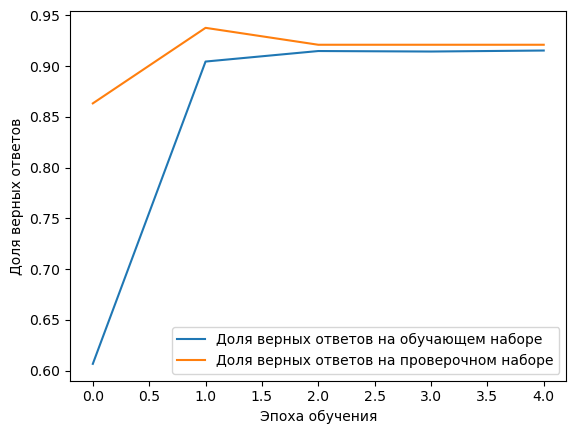

In [156]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [157]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(8, activation='softmax'))

In [158]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [178]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/10
64/64 [==============================] - 7s 104ms/step - loss: 0.2688 - accuracy: 0.9146 - val_loss: 0.2125 - val_accuracy: 0.9311
Epoch 2/10
64/64 [==============================] - 6s 91ms/step - loss: 0.2379 - accuracy: 0.9186 - val_loss: 0.1990 - val_accuracy: 0.9211
Epoch 3/10
64/64 [==============================] - 6s 97ms/step - loss: 0.2260 - accuracy: 0.9151 - val_loss: 0.1864 - val_accuracy: 0.9378
Epoch 4/10
64/64 [==============================] - 6s 93ms/step - loss: 0.2189 - accuracy: 0.9151 - val_loss: 0.1856 - val_accuracy: 0.9211
Epoch 5/10
64/64 [==============================] - 7s 104ms/step - loss: 0.2139 - accuracy: 0.9159 - val_loss: 0.1744 - val_accuracy: 0.9311
Epoch 6/10
64/64 [==============================] - 6s 95ms/step - loss: 0.2105 - accuracy: 0.9153 - val_loss: 0.1764 - val_accuracy: 0.9211
Epoch 7/10
64/64 [==============================] - 6s 100ms/step - loss: 0.2081 - accuracy: 0.9188 - val_loss: 0.1770 - val_accuracy: 0.9211
Epoch 8/10

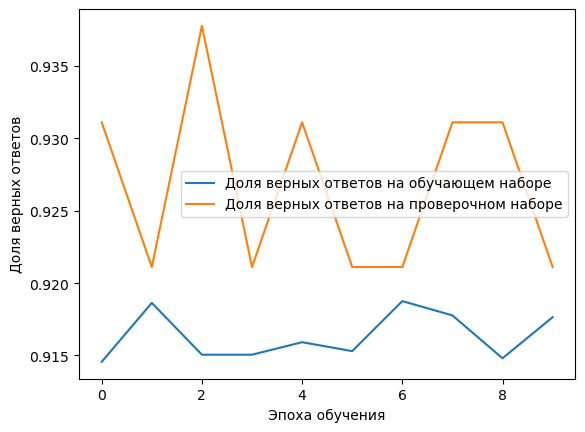

In [179]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [173]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(8, activation='softmax'))

In [174]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [175]:
model_gru.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 32)           320000    
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
Total params: 322,536
Trainable params: 322,536
Non-trainable params: 0
_________________________________________________________________


In [176]:
history_gru = model_gru.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/5
64/64 [==============================] - 31s 182ms/step - loss: 1.8369 - accuracy: 0.3817 - val_loss: 1.4039 - val_accuracy: 0.5156
Epoch 2/5
64/64 [==============================] - 8s 121ms/step - loss: 1.0642 - accuracy: 0.6759 - val_loss: 0.7422 - val_accuracy: 0.7567
Epoch 3/5
64/64 [==============================] - 8s 130ms/step - loss: 0.6295 - accuracy: 0.7917 - val_loss: 0.5120 - val_accuracy: 0.8467
Epoch 4/5
64/64 [==============================] - 8s 123ms/step - loss: 0.4691 - accuracy: 0.8683 - val_loss: 0.3765 - val_accuracy: 0.9178
Epoch 5/5
64/64 [==============================] - 7s 111ms/step - loss: 0.3708 - accuracy: 0.9053 - val_loss: 0.3015 - val_accuracy: 0.9211


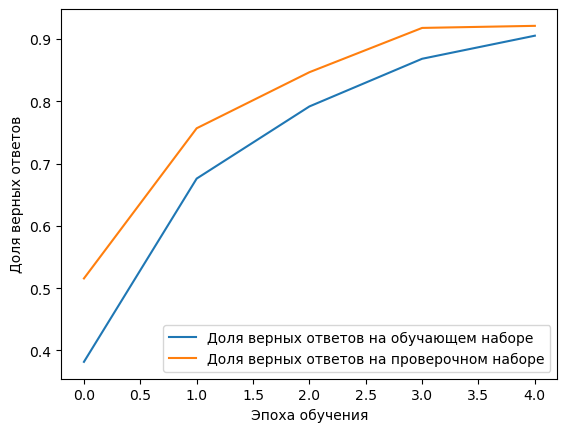

In [177]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [573]:
text = 'Ответственность возложить на специалиста  административно-хозяйственного отдела Кравцову И.Е.'

In [574]:
sequence = tokenizer.texts_to_sequences([text])

In [575]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [576]:
data

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  8,  9,  5, 21, 22,
         6, 58, 19, 25]], dtype=int32)

In [577]:
result = model.predict(data)

1/1 [==============================] - 0s 345ms/step


In [578]:
result

array([[1.]], dtype=float32)

In [560]:
print(X_train.shape),print(y_train.shape)


print(X_test.shape),print(y_test.shape)


(8999, 100)
(8999,)
(1000, 100)
(1000,)


(None, None)

In [44]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '..', '...',' ','"',"'",'`','``','"""',"''",'i','ii','iii','[',']']

/Users/macbook/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/IPython/core/inputtransformer2.py:595: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)


In [285]:
words = []
for token in tokens:
    if token not in punctuation_marks:
        words.append(token)
        
words

['ответственность',
 'за',
 'исполнение',
 'распоряжения',
 'возложить',
 'на',
 'специалиста',
 'третьей',
 'категории',
 'службы',
 'ит',
 'кима',
 'юрия',
 'ивановича']

In [52]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '..', '...',' ','"',"'",'`','``','"""',"''",'i','ii','iii','[',']']
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

### Создаём мешок слов

In [119]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

### Находим уникальные значения департаментов.

In [41]:
departments_set = set(departments)
departments_Unique_list = list(departments_set)
departments_Unique_list

['Служба ИТ',
 'Административно-хозяйственный отдел',
 'Отдел эксплуатации',
 'Отдел разработки систем',
 'Отдел проектирования',
 'Отдел тестирования',
 'Отдел архитектуры',
 'Бухгалтерия']

### Строим однонаправленный граф.

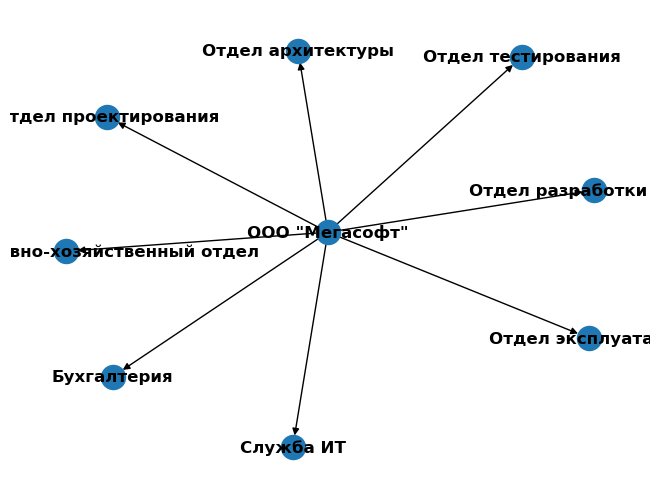

In [5]:
DG = nx.DiGraph()

DG.add_edge('ООО "Мегасофт"', departments_Unique_list[0]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[1]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[2]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[3]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[4]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[5]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[6]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')